In [142]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
#from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model


In [143]:
dataframe = pd.read_csv("./datasets/TON_IoT-Datasets/Train_Test_datasets/Train_Test_IoT_dataset/Train_Test_IoT_Modbus.csv")
raw_data = dataframe.values

In [144]:
data = raw_data[:, 3:6]
labels = raw_data[:, -2]
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.33, random_state=21)

Normalize:

In [145]:
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)


Separate normal and abnormal classes

In [146]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]

anomalous_train_data = train_data[train_labels]
anomalous_test_data = test_data[test_labels]


PLot a normal and an abnormal modbus

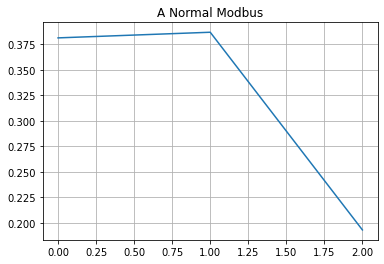

In [147]:
plt.grid()
plt.plot(np.arange(3), normal_train_data[0])
plt.title("A Normal Modbus")
plt.show()


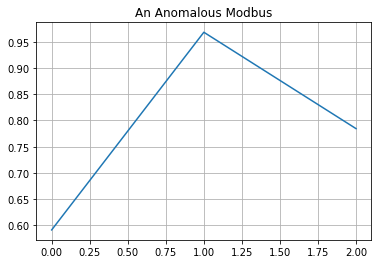

In [148]:
plt.grid()
plt.plot(np.arange(3), anomalous_train_data[0])
plt.title("An Anomalous Modbus")
plt.show()

Build the model - OVERCOMPLETE AE

In [149]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(3, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()


In [150]:
autoencoder.compile(optimizer='adam', loss='mae')

The training is just performed with normal instance. However, test is done with all the instances.

In [151]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=50, 
          batch_size=32,
          validation_data=(test_data, test_data),
          shuffle=True)


Epoch 1/50
734/734 [==============================] - 2s 2ms/step - loss: 0.0605 - val_loss: 0.0177
Epoch 2/50
734/734 [==============================] - 1s 2ms/step - loss: 0.0162 - val_loss: 0.0237
Epoch 3/50
734/734 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0122
Epoch 4/50
734/734 [==============================] - 1s 2ms/step - loss: 0.0117 - val_loss: 0.0133
Epoch 5/50
734/734 [==============================] - 1s 2ms/step - loss: 0.0111 - val_loss: 0.0116
Epoch 6/50
734/734 [==============================] - 1s 2ms/step - loss: 0.0109 - val_loss: 0.0120
Epoch 7/50
734/734 [==============================] - 1s 2ms/step - loss: 0.0102 - val_loss: 0.0094
Epoch 8/50
734/734 [==============================] - 1s 2ms/step - loss: 0.0104 - val_loss: 0.0103
Epoch 9/50
734/734 [==============================] - 1s 2ms/step - loss: 0.0098 - val_loss: 0.0101
Epoch 10/50
734/734 [==============================] - 1s 2ms/step - loss: 0.0095 - val_loss: 0.0114

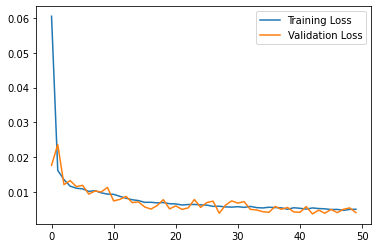

In [152]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()


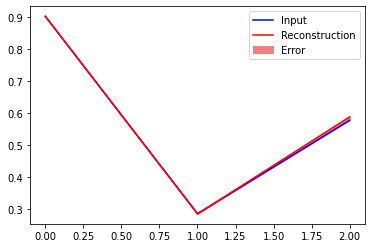

In [153]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(3), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()


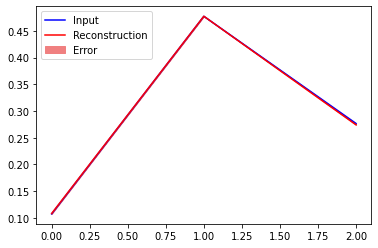

In [154]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(3), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()


Detect anomalies by calculating the reconstruction lose of a fixed threshold.

Calculate the mean error for normal training examples to classify future anomalies if the error is greater than a StandDeviat of the train set.

Error of normal MODBUS in training set

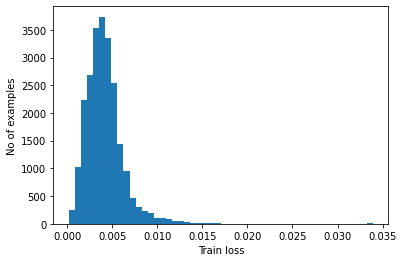

In [155]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()


Select a value a std greater from the mean

In [156]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)


Threshold:  0.0063312966


Error of abnormal MODBUS in test set

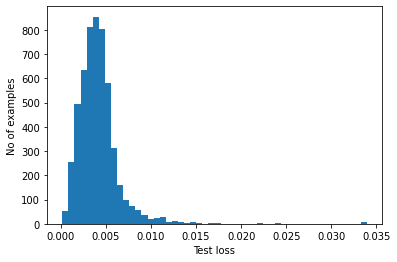

In [157]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()


Classify instance as abnormal if the reconstruction error is greater than the threshold

In [158]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions))) #sensitivity
  print("ROC_AUC = {}".format(roc_auc_score(labels, predictions)))



In [159]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)


Accuracy = 0.3588496887044174
Precision = 0.3193599576831526
Recall = 0.9029725182277061
ROC_AUC = 0.5045428759947145
